In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt 
try:
    from IPython.display import display, Latex 
    try: 
        JUPYTER_AVAILABLE = True
    except NameError:
        JUPYTER_AVAILABLE = False
except ImportError:
    JUPYTER_AVAILABLE = False
%matplotlib inline

In [2]:

def smart_display_latex(latex_obj, description=""): 
    if JUPYTER_AVAILABLE: 
        if description:
            print(description)
        if hasattr(latex_obj, 'data'):
            display(Latex(latex_obj.data))
        else:
            display(latex_obj)
    else: 
        if description:
            print(description)
        if hasattr(latex_obj, 'data'): 
            latex_str = latex_obj.data 
            clean_str = latex_str.replace('$$', '').replace('$', '') 
            clean_str = clean_str.replace('\\rangle', '⟩')
            clean_str = clean_str.replace('\\langle', '⟨')
            clean_str = clean_str.replace('\\frac{\\sqrt{2}}{2}', '1/√2')
            clean_str = clean_str.replace('\\frac{1}{2}', '1/2')
            clean_str = clean_str.replace('\\sqrt{2}', '√2')
            clean_str = clean_str.replace('\\otimes', '⊗')
            print(f"  {clean_str}")
        else:
            print(f"  {latex_obj}")
 

def draw_and_save_circuit(circuit, title):
    fig = circuit.draw(output='mpl', style='iqp')
    if title:
        plt.title(title)
    plt.tight_layout() 
    plt.show() 


In [30]:
def z_k_rotation(qc: QuantumCircuit, qubits, theta: float): 
    for i in range(len(qubits)-1):
        qc.cx(qubits[i], qubits[i+1])
    qc.rz(2*theta, qubits[-1])
    for i in reversed(range(len(qubits)-1)):
        qc.cx(qubits[i], qubits[i+1])


def build_circuit(kappa: float, t: float) -> QuantumCircuit:
    
    theta = kappa * t / 2 
    qc = QuantumCircuit(4)

    # Prepare (|00⟩+|11⟩)^⊗2, two Bell states 
    qc.rx(np.pi/10, 0)  
    qc.cx(0, 1)  

    qc.rx(np.pi/10, 2)  
    qc.cx(2, 3)   
    qc.barrier()
    # Global phase from the identity term: exp(-i * theta * I) (optional)
    # qc.global_phase = qc.global_phase - theta

    for _ in range(20):
        # Apply exp(-i * theta * Z1 Z3)
        z_k_rotation(qc, [0, 2], theta)
        qc.barrier()

        # Apply exp(-i * theta * Z2 Z4)
        z_k_rotation(qc, [1, 3], theta)
        qc.barrier()

        # Apply exp(-i * theta * Z1 Z2 Z3 Z4)
        z_k_rotation(qc, [0, 1, 2, 3], theta)
        qc.barrier()

    return qc


In [31]:

def analyze_tensor_decomposition(state_vector):
    """
    Analyze the tensor decomposition properties of a 4-qubit state.
    Returns Schmidt rank and decomposition details.
    """ 
    latex_state = state_vector.draw(output='latex')
    smart_display_latex(latex_state)
    
    amps = np.array(state_vector.data)
    C = amps.reshape(4, 4)  # Reshape as (01)|(23)
    
    # SVD for Schmidt decomposition
    u, s, vh = np.linalg.svd(C)
    rank = np.sum(s > 1e-10)
    
    print(f"Schmidt decomposition analysis:")
    print(f"- Schmidt rank: {rank}")
    print(f"- Schmidt values: {s[s > 1e-10]}")
    
    if rank == 1:
        print(f"- State is SEPARABLE: |ψ⟩ = |ψ₁⟩ ⊗ |ψ₂⟩")
        # Extract factors
        left_factor = u[:, 0] * np.sqrt(s[0])
        right_factor = vh[0, :] * np.sqrt(s[0])
        print(f"- Schmidt decomposition: |ψ⟩ = {s[0]:.6f} |ψ_L⟩ ⊗ |ψ_R⟩")
        
        # Create Statevector objects for LaTeX display
        left_sv = Statevector(left_factor)
        right_sv = Statevector(right_factor)
        
        left_latex = left_sv.draw(output='latex')
        right_latex = right_sv.draw(output='latex')
        
        smart_display_latex(left_latex, "  Left state |ψ_L⟩ (qubits 01):")
        smart_display_latex(right_latex, "  Right state |ψ_R⟩ (qubits 23):")
        return rank, left_factor, right_factor
    else:
        print(f"- State is ENTANGLED (rank {rank})")
        print(f"- Schmidt decomposition: |ψ⟩ = Σᵢ λᵢ |uᵢ⟩ ⊗ |vᵢ⟩")
        for i in range(min(rank, 2)):  # Show first 2 terms
            left_vec = u[:, i]
            right_vec = vh[i, :]
            print(f"  Term {i+1}: {s[i]:.6f} |u_{i+1}⟩ ⊗ |v_{i+1}⟩")
            
            # Create Statevector objects for LaTeX  
            left_sv = Statevector(left_vec)
            right_sv = Statevector(right_vec)
            
            left_latex = left_sv.draw(output='latex')
            right_latex = right_sv.draw(output='latex')
            
            smart_display_latex(left_latex, f"    |u_{i+1}⟩ (qubits 01):")
            smart_display_latex(right_latex, f"    |v_{i+1}⟩ (qubits 23):")
        return rank, u, vh


def tensor_decomposition_check(kappa=1.0, t=0.01):   
    print("=== Tensor Decomposition Analysis ===")
    
    # Create initial state circuit (separate from evolution)
    qc_initial = QuantumCircuit(4)
    qc_initial.h(0); qc_initial.cx(0, 1)
    qc_initial.h(2); qc_initial.cx(2, 3)
    sv_initial = Statevector.from_instruction(qc_initial)
    
    print("\nInitial State (|00⟩+|11⟩)^⊗2:")
    rank_init, _, _ = analyze_tensor_decomposition(sv_initial)
    
    print("\n" + "-" * 60)
    
    # Create evolution circuit and analyze final state
    qc_final = build_circuit(kappa=kappa, t=t)
    
    print("\nDrawing and saving evolution circuit...")
    draw_and_save_circuit(qc_final, "Full Evolution Circuit")
    
    sv_final = Statevector.from_instruction(qc_final)
    
    print("\nFinal State after evolution:")
    rank_final, _, _ = analyze_tensor_decomposition(sv_final)
    
    print(f"\nComparison:")
    print(f"Initial state rank: {rank_init} (separable: rank=1)")
    print(f"Final state rank:   {rank_final} (entangled: rank>1)")
 

=== Tensor Decomposition Analysis ===

Initial State (|00⟩+|11⟩)^⊗2:


<IPython.core.display.Latex object>

Schmidt decomposition analysis:
- Schmidt rank: 1
- Schmidt values: [1.]
- State is SEPARABLE: |ψ⟩ = |ψ₁⟩ ⊗ |ψ₂⟩
- Schmidt decomposition: |ψ⟩ = 1.000000 |ψ_L⟩ ⊗ |ψ_R⟩
  Left state |ψ_L⟩ (qubits 01):


<IPython.core.display.Latex object>

  Right state |ψ_R⟩ (qubits 23):


<IPython.core.display.Latex object>


------------------------------------------------------------

Drawing and saving evolution circuit...


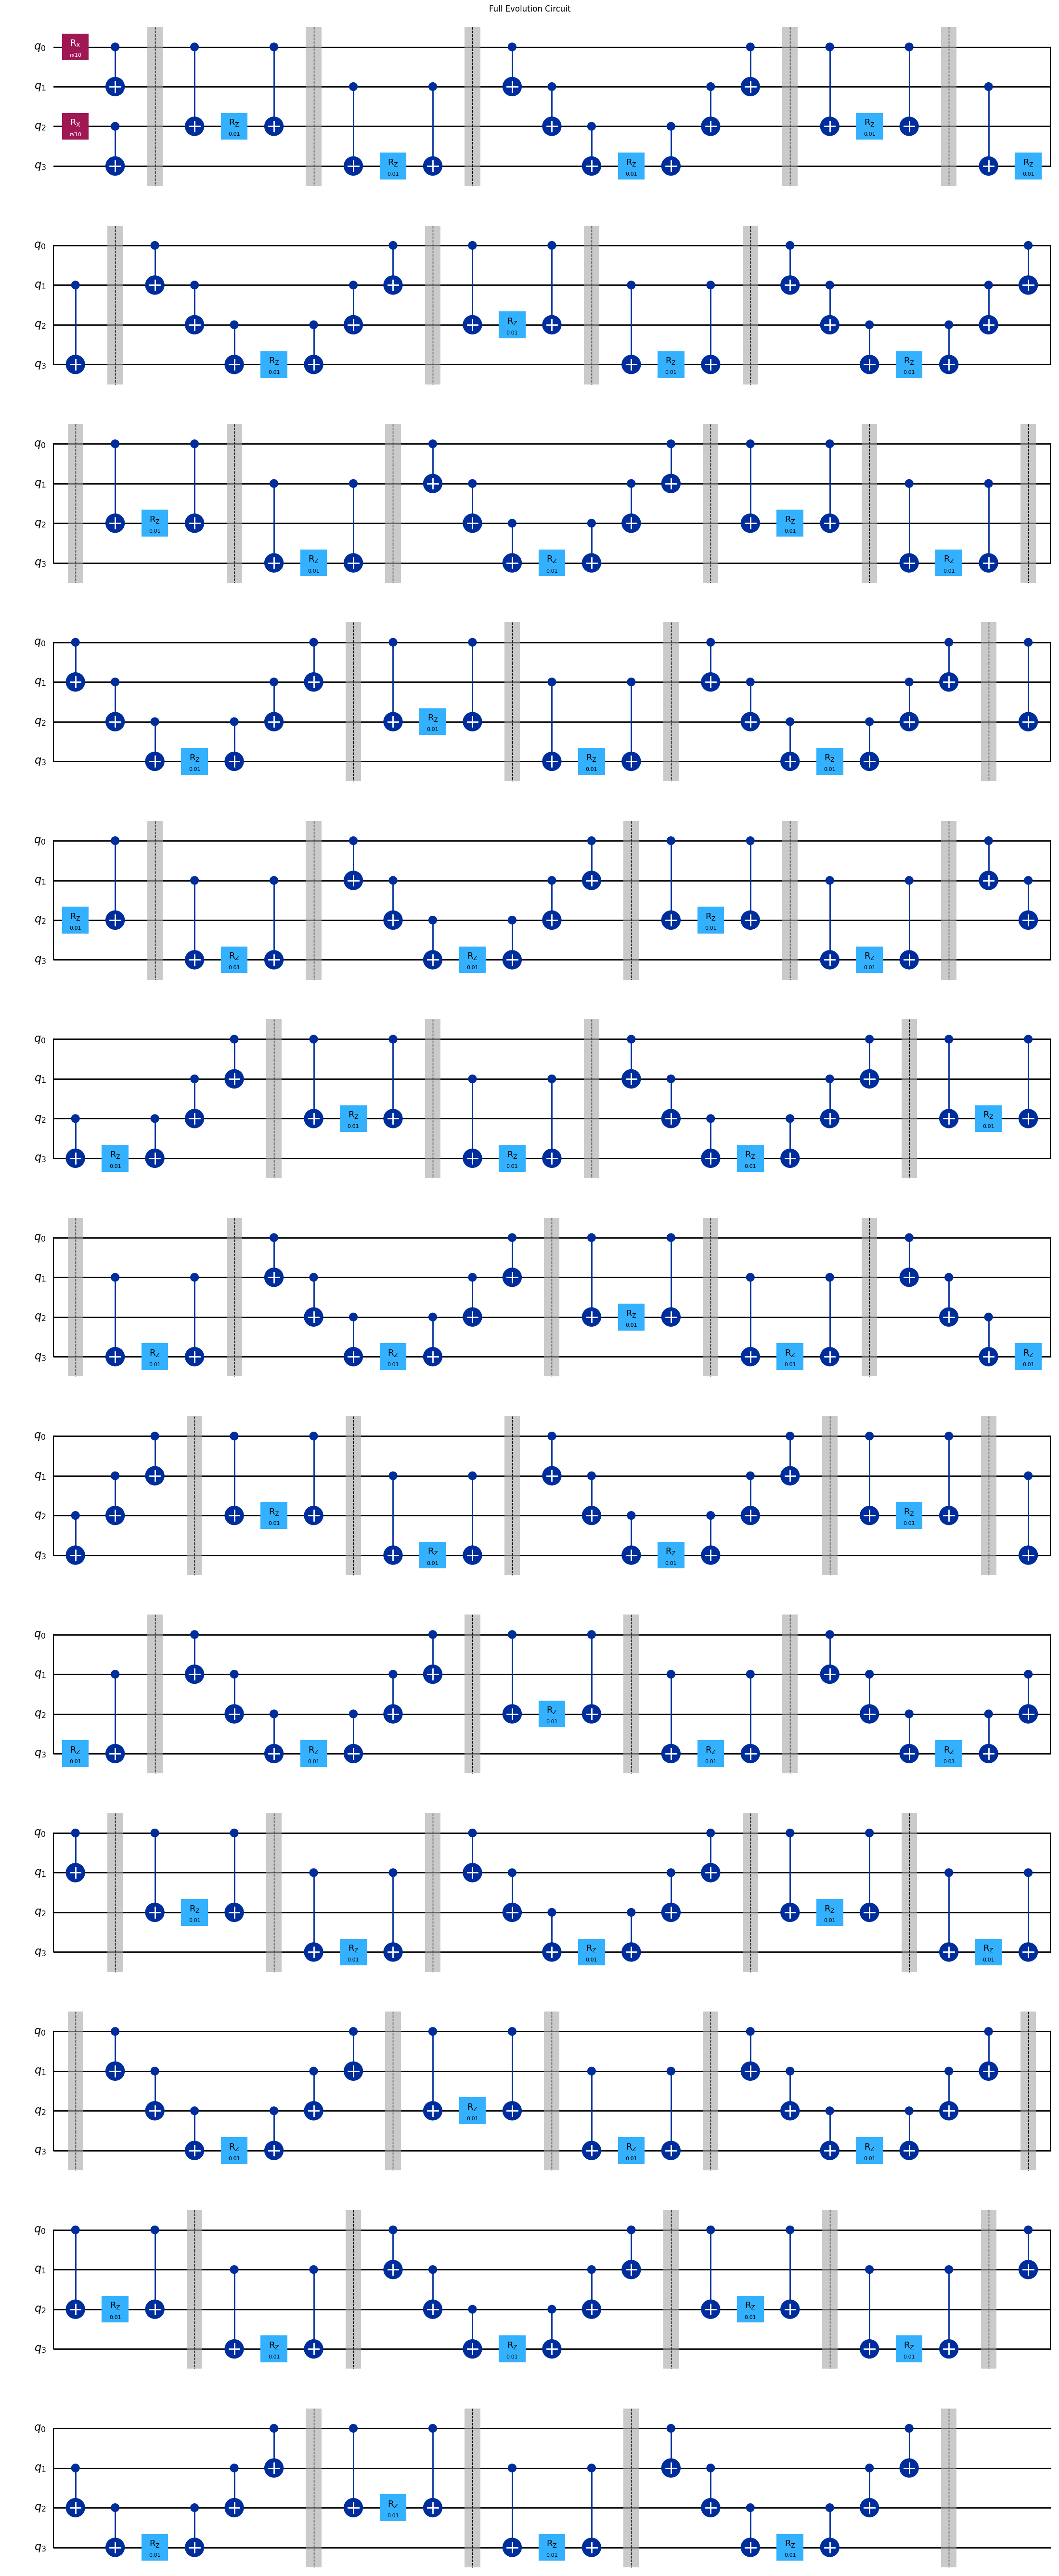


Final State after evolution:


<IPython.core.display.Latex object>

Schmidt decomposition analysis:
- Schmidt rank: 2
- Schmidt values: [0.99982707 0.01859629]
- State is ENTANGLED (rank 2)
- Schmidt decomposition: |ψ⟩ = Σᵢ λᵢ |uᵢ⟩ ⊗ |vᵢ⟩
  Term 1: 0.999827 |u_1⟩ ⊗ |v_1⟩
    |u_1⟩ (qubits 01):


<IPython.core.display.Latex object>

    |v_1⟩ (qubits 23):


<IPython.core.display.Latex object>

  Term 2: 0.018596 |u_2⟩ ⊗ |v_2⟩
    |u_2⟩ (qubits 01):


<IPython.core.display.Latex object>

    |v_2⟩ (qubits 23):


<IPython.core.display.Latex object>


Comparison:
Initial state rank: 1 (separable: rank=1)
Final state rank:   2 (entangled: rank>1)


In [32]:

tensor_decomposition_check()
